# Understand how formulas work

## Forward diffusion process

Quote from paper:
What distinguishes diffusion models from other types of latent variable models is that the approximate posterior q(x1:T |x0), called the forward process or diffusion process, is fixed to a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule β1 , . . . , βT:

$q(x_{1:T} |x_0) := \prod_{t=1}^n q(x_t|x_t−1)$ <br/>
$q(x_t|x_{t−1}) := \mathcal{N}(x_t, \sqrt{1 − β_t}x_{t−1}, β_tI)$

Let's implement the process above in Python

In [1]:
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import numpy as np
import utils

0.28098396035545714
0.09042397518281257
-1.162607986656665
-1.5091542787186096
1.3771569591702402
-0.05548742848238311


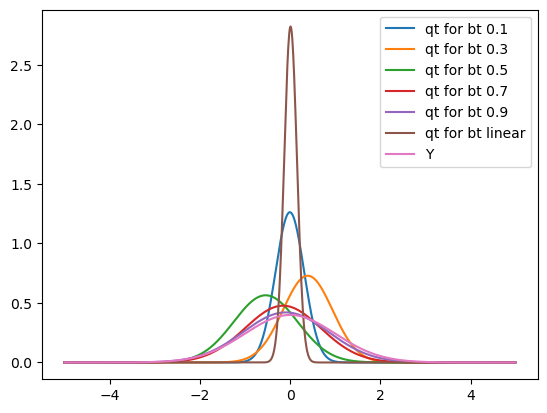

In [296]:
# Implement q function with 1 dimensional argument
# We have to fix a seed to get the same results

# Fix a seed to get the same results
utils.seed_everything(1000)

# Number of timesteps
timestep = 800

# Our interval
xs = np.arange(-5, 5, 0.01)

# Apply normal pdf to xs with 0 mean and 1 variance (Just to check graph with our graphs)
y_results = norm.pdf(xs, 0, 1)

different_schedules = [
    # constant
    np.ones(timestep) * 0.1,
    np.ones(timestep) * 0.3,
    np.ones(timestep) * 0.5,
    np.ones(timestep) * 0.7,
    np.ones(timestep) * 0.9,
    # linear change (from paper)
    np.linspace(1e-4, 0.02, timestep)
]

# set x0 some random value from -1 to 1
x0 = 3

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = bt[t]

        # Q is a normal distribution, so to get the next xt, we just get random element from our distribution
        xt = np.random.normal(mean, math.sqrt(variance))
    print(xt)
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

In previous code we have a line:

`xt = np.random.normal(mean, math.sqrt(variance))`

Which means we always get some random variable. If we want to make a backpropagation in the future, it's hard to do it, because we can not make deriviative $x_t$ by $x_{t-1}$.
To avoid this situation lets make reparametrization trick.

$x_t \sim q(x_t | x_{t-1}) := \mathcal{N}(x_t, \mu_{t-1}, \delta_{t-1} ^2 ) $ <br/>
$x_t = \mu_{t-1} + \delta_{t-1} * \epsilon$, where $\epsilon \sim \mathcal{N}(0, I)$

0.2809839603554573
0.09042397518281259
-1.1626079866566648
-1.5091542787186096
1.3771569591702402
0.06682475236716073


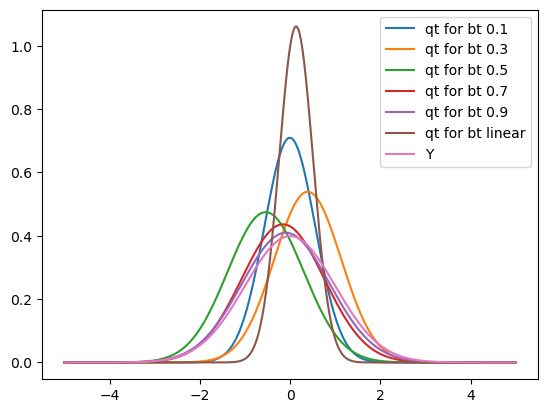

In [289]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:

    # Set xt to zero, which will be used as x(t-1) like in sqrt(1-b) * x(t-1)
    xt = x0

    q_results = None

    # A simple loop by timestep
    for t in range(timestep):

        # Calculate the mean as in the formula
        mean = math.sqrt(1 - bt[t]) * xt

        # Calculate the variance
        variance = math.sqrt(bt[t])

        # Get eps from normal distribution
        eps = np.random.normal(0, 1)
        
        # Calculate our xt
        xt = mean + variance * eps
    print(xt)
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

As we can see first two methods leads us to some normal distribution in the end for all beta schedules.

Right now we have a direct formula to compute $x_t$. When we are working in one dimensional, it's so easy and fast to compute $x_t$, but if we want to work in 100D, 1000D, 10000D, etc. our loop will be a big pain and have a bad performance.

Can we avoid our timestep loop? Let's go to formulas

$\alpha_t = 1 - \beta_t, \bar \alpha_t = \prod_{i=1}^t\alpha_i$ <br/>
$x_t = \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t = \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1})} * \epsilon_{t-1} + \sqrt{1 - \alpha_t} * \epsilon_t$

$\epsilon_t \sim \mathcal{N}(0, \delta_t^2 I)$ and $\epsilon_{t-1} \sim \mathcal{N}(0, \delta_{t-1}^2 I)$. So their merge will be $\mathcal{N}(0, (\delta_t^2 + \delta_{t-1}^2)I)$. Rewrite the formula above:

$x_t=\sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{\alpha_t * (1 - \alpha_{t-1}) + 1 - \alpha_t} * \bar{\epsilon_{t-2}} = \sqrt{\alpha_t * \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t * \alpha_{t-1}} * \bar{\epsilon_{t-2}}$ <br/>

And then we can continue this line until we reach x0: <br/>
$x_t=\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}$

Lets try to implement it and compare results with previous graphs.

-0.8044583035248052
0.3209315470898572
-0.025482880472072197
0.6443238284268143
-0.3007966727870204
0.5641467811220456


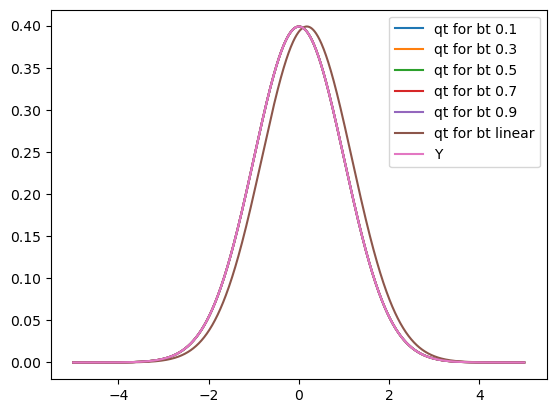

In [290]:
# Fixed seed to get the same results
utils.seed_everything(1000)

for bt in different_schedules:
    alpha_t = 1 - bt
    cumprod_alpha_t = np.cumprod(alpha_t)
    mean = math.sqrt(cumprod_alpha_t[-1]) * x0
    variance = math.sqrt(1 - cumprod_alpha_t[-1])
    eps = np.random.normal(0, 1)
    variance = variance
    xt = mean + eps * variance
    print(xt)
    q_results = norm.pdf(xs, mean, math.sqrt(variance))
    plt.plot(xs, q_results, label=f"qt for bt {bt[0] if bt[0] == bt[-1] else 'linear'}")
plt.plot(xs, y_results, label="Y")
plt.legend()
plt.show()

As we can see the last method take us closer to Normal distribution with zero mean and one variance.
So, now we have transformation of a point(point will be an image) to point from Normal distribution(image with a noise).

## Reverse diffusion process

### Problem with reverse diffusion process

What about a reverse diffusion process:
$q(x_{t-1}|x_t)$ ?

As we can see, we don't have enough data to make this transformation, but we can do something like this:
$q(x_{t-1}|x_t, x_0)$

What doest it mean? We try to find the distribution $x_{t-1}$, knowing distribution $x_t, x_0$.

I will provide formulas of this calculation later. But right now question is: can we draw $q(x_{t-1}|x_t)$ from $q(x_{t-1}|x_t, x_0)$ ?

Yes, for next point I had to remember some formulas and rules from statistic theory ([very good explanation](https://stats.libretexts.org/Courses/Saint_Mary's_College_Notre_Dame/MATH_345__-_Probability_(Kuter)/1%3A_What_is_Probability)).

Let's do some magic.

$q(x_{t-1}|x_t, x_0) = \frac{q(x_{t-1}, x_t, x_0)}{q(x_t, x_0)}$ (1)<br/><br/>
$q(x_{t-1}|x_t)=\int_{x_0} q(x_{t-1}, x_0|x_t) \mathrm{d}x_0$ (2) <br/><br/>
$q(x_{t-1}, x_0| x_t) = \frac{q(x_{t-1}, x_0, x_t)}{q(x_t)}$ (3) <br/>
Drawing numerator from (1) and (3) and assining them to each other, we have <br/><br/>
$q(x_{t-1}|x_t, x_0) * q(x_t, x_0) = q(x_{t-1}, x_0| x_t) * q(x_t) => q(x_{t-1}, x_0| x_t) = q(x_{t-1}|x_t, x_0) * \frac{q(x_t, x_0)}{q(x_t)}$ <br/><br/>
$ q(x_{t-1}, x_0| x_t) = q(x_{t-1}|x_t, x_0) * q(x_0|x_t)$ <br/><br/>
And redraw (2): <br/><br/>
$q(x_{t-1}|x_t)=\int q(x_{t-1}|x_t, x_0) * q(x_0|x_t) \mathrm{d}x_0$

With Bayes formula we can draw $q(x_0|x_t)$ as $\begin{aligned} q(x_t|x_0) * \frac{q(x_0)}{q(x_t)} \end{aligned}$

So to calculate $q(x_{t-1}|x_t)$ we should make integral through all x0 (our images dataset), which means a lot of computations and super slow as the result.

**Let's work with $q(x_{t-1}|x_t, x_0)$**

First of all, we should say, that if $\beta$ is small and $q(x_t|x_{t-1})$ is Gaussian, then $q(x_{t-1}|x_t)$ is Gaussian too. A quote from paper:

"For both Gaussian and binomial diffusion, for continuous diffusion (limit of small step size β) the reversal of the diffusion process has the identical functional form as the forward process (Feller, 1949)."

I tried to read Feller original, but it was so hard to understand, so let's take this fact as true.

So if it is Gaussian, we should try to find $\mu$ and $\delta$ of this Gaussian. Lets do it.

Using Bayes' rule we have (took part of calculations from [Lil Log article](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)): <br/>
$\begin{aligned}q(x_{t-1}|x_t, x_0) = q(x_{t}|x_{t-1},x_0) * \frac{q(x_{t}|x_0)}{q(x_{t-1}|x_0)}\end{aligned}$<br/>
$\begin{aligned}\propto \exp (-\frac{1}{2} * (\frac{(x_t - \sqrt{\alpha_t}x_{t-1})^2}{\beta_t} + \frac{(x_{t-1} - \sqrt{\bar \alpha_{t-1}}x_0)^2}{1 - \bar \alpha_{t-1}} - \frac{(x_{t} - \sqrt{\bar \alpha_{t}}x_0)^2}{1 - \bar \alpha_t})) \end{aligned}$<br/>
$\begin{aligned}
&= \exp (-\frac{1}{2} (\frac{\mathbf{x}_t^2 - 2\sqrt{\alpha_t} \mathbf{x}_t \color{blue}{\mathbf{x}_{t-1}} \color{black}{+ \alpha_t} \color{red}{\mathbf{x}_{t-1}^2} }{\beta_t} + \frac{ \color{red}{\mathbf{x}_{t-1}^2} \color{black}{- 2 \sqrt{\bar{\alpha}_{t-1}} \mathbf{x}_0} \color{blue}{\mathbf{x}_{t-1}} \color{black}{+ \bar{\alpha}_{t-1} \mathbf{x}_0^2}  }{1-\bar{\alpha}_{t-1}} - \frac{(\mathbf{x}_t - \sqrt{\bar{\alpha}_t} \mathbf{x}_0)^2}{1-\bar{\alpha}_t} ) ) \\
&= \exp\Big( -\frac{1}{2} \big( \color{red}{(\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}})} \mathbf{x}_{t-1}^2 - \color{blue}{(\frac{2\sqrt{\alpha_t}}{\beta_t} \mathbf{x}_t + \frac{2\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} \mathbf{x}_0)} \mathbf{x}_{t-1} \color{black}{ + C(\mathbf{x}_t, \mathbf{x}_0) \big) \Big)}
\end{aligned}$

Just reminder:

$ N(x, \mu, \delta^2) ~ x \propto \exp (-1/2 * \frac{(x - \mu) ^ 2}{\delta^2}) $

Look detally at:

$\begin{aligned}\frac{(x - \mu) ^ 2}{\delta^2} = \frac{(x^2 - 2x\mu + \mu^2)}{\delta^2} = \frac{1}{\delta^2} * x^2 - 2 * \frac{\mu}{\delta^2} * x + ... \end{aligned}$

If we have $A * x ^ 2$, then $\delta^2 = 1 / A$. Similar for $\mu: B * x => \mu = -\frac{1}{2} * \delta^2 * B $

Draw our mean and variance for $q(x_{t-1}|x_t, x_0)$

$\begin{aligned} (\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}}) \mathbf{x}_{t-1}^2 => \delta^2 = 1/A = 1 / (\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}}) = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t \end{aligned}$ <br/>
$\begin{aligned} -(\frac{2\sqrt{\alpha_t}}{\beta_t} \mathbf{x}_t + \frac{2\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} \mathbf{x}_0) \mathbf{x}_{t-1} => \mu = -\frac{1}{2} * \delta^2 * B = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_0 \end{aligned}$

Now $q(x_{t-1}|x_t, x_0) ~ N(x_{t-1}, \mu(x_t, x_0), \tilde \beta_tI)$. Now we have:

$\begin{aligned} \tilde \beta_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t \end{aligned}$ <br/>
$\begin{aligned} \mu(x_t, x_0) = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{1 - \bar{\alpha_{t}}}x_0 \end{aligned}$

Recall that $x_t=\sqrt{\bar \alpha_t} x_0 + \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}$, draw $x_0$ through $x_t$

$\begin{aligned}x_0=\frac{1}{\sqrt{\bar \alpha_t}} (x_t - \sqrt{1 - \bar \alpha_t} * \bar{\epsilon}) \end{aligned}$

Next, draw our new $\tilde \mu_t$ without $x_0$

$\begin{aligned} \tilde \mu_t = \frac{\sqrt{\alpha_t}(1- \bar \alpha_{t-1})}{1 - \bar \alpha_t}x_t + \frac{\sqrt{\bar \alpha_{t-1}} * \beta_t}{(1 - \bar{\alpha_{t}})\sqrt{\bar \alpha_t}}(x_t - \sqrt{1 - \bar \alpha_t} * \bar{\epsilon})=\frac{1}{\sqrt{\alpha_t}}x_t - \frac{1}{\sqrt{\alpha_t}} * \frac{\sqrt{1 - \bar \alpha_t}}{1 - \bar \alpha_t} * \beta_t * \bar {\epsilon} \end{aligned}$

Recall $\beta_t = 1 - \alpha_t$ we have

$\begin{aligned} \tilde \mu_t = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar \alpha_t}} \bar {\epsilon}) \end{aligned}$

### Transition from $q(x_{t-1}|x_t)$ to $p_\theta(x_{t-1}|x_t)$

As we saw before, we can not calculate $q(x_{t-1}|x_t)$ , so we introduce a model $p_\theta(x_{t-1}|x_t)$, which approximate our q.
As we discussed earlier $q(x_{t-1}|x_ty)$ is Gaussian, so $p_\theta(x_{t-1}|x_t)$ is Gaussian too. So we have:

$p_\theta(x_{t-1}|x_t) = N(x_{t-1}, \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)) \quad p(x_{0...T}) = p(x_T) * \prod_{t=1}^T p_\theta(x_{t-1}|x_t)$

In [91]:
import torch

def linear_schedule(num_timesteps):
  beta_start = 1e-4
  beta_end = 0.02
  betas = torch.linspace(beta_start, beta_end, num_timesteps)
  betas = torch.cat((torch.tensor([0]), betas))
  return betas

def cosine_schedule(num_timesteps, s=0.008):
  def f(t):
    return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
  x = torch.linspace(0, num_timesteps, num_timesteps + 1)
  alphas_cumprod = f(x) / f(torch.tensor([0]))
  betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
  betas = torch.clip(betas, 0.0001, 0.999)
  return betas

In [92]:
import requests
from PIL import Image

url = 'https://images.pexels.com/photos/1557208/pexels-photo-1557208.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2'
image_raw_data = requests.get(url, stream=True).raw
image = Image.open(image_raw_data)
# image

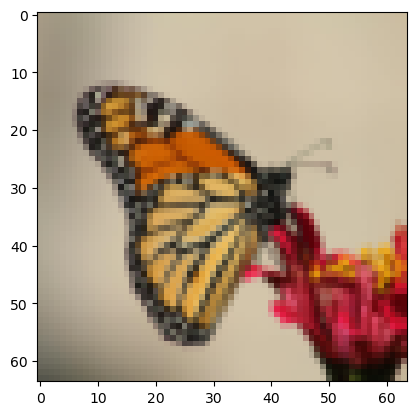

In [272]:
from torchvision.transforms import RandomHorizontalFlip, Compose, ToTensor, CenterCrop, Resize, Normalize

image_size = 64
transform = Compose([
  Resize((image_size, image_size)),
  # CenterCrop(image_size),
#   RandomHorizontalFlip(),
  ToTensor(),
#   Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

x0_image = transform(image).unsqueeze(0)
plt.imshow(x0_image[0].permute(1,2,0))

torch.Size([1, 3, 64, 64])
tensor(0.0064)
tensor([[[[0.9903]]]]) tensor([[[[0.1391]]]])


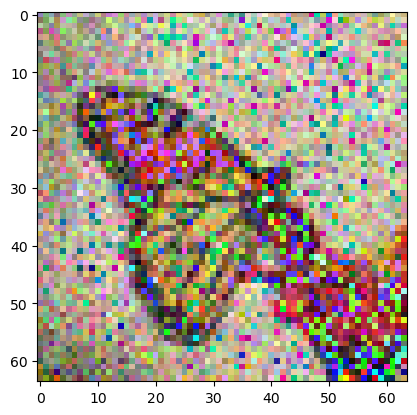

In [280]:
utils.seed_everything(1000)

x0_image = transform(image).unsqueeze(0)

def sample_by_t(tensor_to_sample, timesteps, x_shape):
    batch_size = timesteps.shape[0]
    sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
    sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
    return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    print(sqrt_alphas_bar_t[-1])
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    print(sqrt_alphas_bar_t_sampled, sqrt_1_minus_alphas_bar_t_sampled)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t

def get_noisy_image(x0, t, transform=Compose([ToPILImage()])):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image

noisy_image = get_noisy_image(x0_image, t)
plt.imshow(noisy_image)

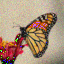

In [202]:
from torchvision.transforms import ToPILImage

reverse_transform_pil = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
  ToPILImage()
])

reverse_transform_tensor = Compose([
  Normalize(mean=(-1, -1, -1), std=(2, 2, 2)),
])

num_timesteps = 1000
betas_t = linear_schedule(num_timesteps)

alphas_t = 1. - betas_t
alphas_bar_t = torch.cumprod(alphas_t, dim=0)
alphas_bar_t_minus_1 = torch.cat((torch.tensor([0]), alphas_bar_t[:-1]))
one_over_sqrt_alphas_t = 1. / torch.sqrt(alphas_t)
sqrt_alphas_t = torch.sqrt(alphas_t)
sqrt_alphas_bar_t = torch.sqrt(alphas_bar_t)
sqrt_alphas_bar_t_minus_1 = torch.sqrt(alphas_bar_t_minus_1)
sqrt_1_minus_alphas_bar_t = torch.sqrt(1. - alphas_bar_t)
# the variance of q(xₜ₋₁ | xₜ, x₀) as in part 3
posterior_variance = (1. - alphas_bar_t_minus_1) / (1. - alphas_bar_t) * betas_t

def sample_by_t(tensor_to_sample, timesteps, x_shape):
  batch_size = timesteps.shape[0]
  sampled_tensor = tensor_to_sample.gather(-1, timesteps.cpu())
  sampled_tensor = torch.reshape(sampled_tensor, (batch_size,) + (1,) * (len(x_shape) - 1))
  return sampled_tensor.to(timesteps.device)

def sample_q(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alphas_bar_t_sampled = sample_by_t(sqrt_alphas_bar_t, t, x0.shape)
    sqrt_1_minus_alphas_bar_t_sampled = sample_by_t(sqrt_1_minus_alphas_bar_t, t, x0.shape)
    x_t = sqrt_alphas_bar_t_sampled * x0 + sqrt_1_minus_alphas_bar_t_sampled * noise
    return x_t
     

def get_noisy_image(x0, t, transform=reverse_transform_pil):
    x_noisy = sample_q(x0, t)
    noise_image = transform(x_noisy.squeeze())
    return noise_image
     

import matplotlib.pyplot as plt
def show_noisy_images(noisy_images):
    num_of_image_sets = len(noisy_images)
    num_of_images_in_set = len(noisy_images[0])
    image_size = noisy_images[0][0].size[0]

    full_image = Image.new('RGB', (image_size * num_of_images_in_set + (num_of_images_in_set - 1), image_size * num_of_image_sets + (num_of_image_sets - 1)))
    for set_index, image_set in enumerate(noisy_images):
        for image_index, image in enumerate(image_set):
            full_image.paste(image, (image_index * image_size + image_index, set_index * image_size + set_index))

    plt.imshow(full_image)
    plt.axis('off')
    return full_image

t = torch.tensor([20])

get_noisy_image(x0, t)

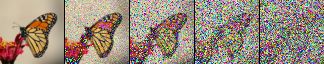

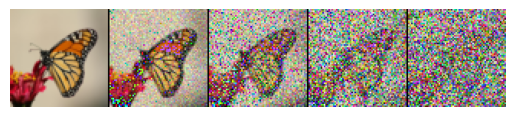

In [129]:
show_noisy_images([[get_noisy_image(x0, torch.tensor([t])) for t in [0, 50, 100, 150, 200]]])
